In [1]:
!pwd

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/TSMO


In [2]:
%cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing


In [3]:
import csv
import pandas as pd
import numpy as np
#import geopandas as gpd
#import networkx as nx
import math
import pickle

import datetime
from datetime import datetime as dt
from collections import Counter
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import *

### 1. Hyperparameters

In [4]:
# Time
start_date = dt(2022, 2, 14)
end_date = dt(2023, 2, 12)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates

In [5]:
# Shapefile for Visualization
gdf_tmc_TSMO = gpd.read_file("../data/TSMO/TSMO_tmc_shape/TSMO_tmc_shape_for_sjoin.geojson")  # 1591 TMC segments in TSMO (selected from Carroll, Howard and Baltimore) used for spatial join
gdf_tmc_TSMO = gdf_tmc_TSMO.rename(columns={"tmc":"id_tmc"})

gdf_xd_TSMO = gpd.read_file("../data/TSMO/TSMO_xd_shape/TSMO_xd_shape_for_sjoin.geojson")  # 2501 XD segments in TSMO (selected from Carroll, Howard and Baltimore) used for spatial join

In [7]:
# Set of Segments of Interest
set_tmc_segments_with_upstream = pickle.load(open("./TSMO/TSMO_set_tmc_segments_with_upstream.pkl", "rb"))  # 1433 TMC segments with upstream segments, from which we filter those with speed data and select our final set of target TMC segments
set_xd_setments_str = pickle.load(open("./TSMO/TSMO_set_xd_str_segments_matched_with_tmc.pkl", "rb"))  # 2427 XD segments with matched TMC segments, from which we filter those with speed data and help impute missing TMC speed data if any

### 2. Downsample Raw Speed Data Files

Execute this code block ONLY IF downsampled csv data are not available on file

tmc process and xd process CANNOT be executed simultaneously, otherwise the notebook will encounter kernel crash


In [11]:
# Take ~35 min to execute
# downsampled_tmc_1min_all: shape ()
downsampled_tmc_1min_all = downsample_large_dataset(type="tmc", 
                                                    input_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_1min_all/TSMO_tmc_1min_all/TSMO_tmc_1min_all.csv", 
                                                    output_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_1min_all/TSMO_downsampled_tmc_1min_all.csv",
                                                    set_segments=set_tmc_segments_with_upstream,
                                                    busi_date=busi_date,
                                                    start_time=start_time,
                                                    end_time=end_time)

75it [17:07, 13.70s/it]


Finished reading chunks!


In [12]:
downsampled_xd_1min = downsample_large_dataset(type="xd", 
                                                input_file_path="/Volumes/Hao's WD/TSMO/TSMO_xd_1min/TSMO_xd_1min.csv", 
                                                output_file_path="/Volumes/Hao's WD/TSMO/TSMO_xd_1min/TSMO_downsampled_xd_1min.csv",
                                                set_segments=set_xd_setments_str,
                                                busi_date=busi_date,
                                                start_time=start_time,
                                                end_time=end_time)

2it [00:32, 16.45s/it]

In [ ]:
# Take ~2 min to execute
# downsampled_tmc_1min_truck_2022_bh: shape (9509162, 7)
downsampled_tmc_5min_truck_2022 = downsample_large_dataset(type="tmc", 
                                                    input_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_tmc_5min_truck_2022/TSMO_tmc_5min_truck_2022.csv", 
                                                    output_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_truck_2022.csv",
                                                    set_segments=set_tmc_segments_with_upstream,
                                                    busi_date=busi_date,
                                                    start_time=start_time,
                                                    end_time=end_time)
# Take ~31 sec to execute
# downsampled_tmc_1min_truck_2023_bh: shape (1268097, 7)
downsampled_tmc_5min_truck_2023 = downsample_large_dataset(type="tmc", 
                                                    input_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_tmc_5min_truck_2023/TSMO_tmc_5min_truck_2023.csv", 
                                                    output_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_truck_2023.csv",
                                                    set_segments=set_tmc_segments_with_upstream,
                                                    busi_date=busi_date,
                                                    start_time=start_time,
                                                    end_time=end_time)

In [7]:
# Take ~4 min to execute
# downsampled_tmc_1min_pv_2022_bh: shape (14498618, 7)
downsampled_tmc_5min_pv_2022 = downsample_large_dataset(type="tmc", 
                                                    input_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_tmc_5min_pv_2022/TSMO_tmc_5min_pv_2022.csv", 
                                                    output_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_pv_2022.csv",
                                                    set_segments=set_tmc_segments_with_upstream,
                                                    busi_date=busi_date,
                                                    start_time=start_time,
                                                    end_time=end_time)

# Take ~1.5 min to execute
# downsampled_tmc_1min_pv_2023_bh: shape (1860391, 7)
downsampled_tmc_5min_pv_2023 = downsample_large_dataset(type="tmc", 
                                                    input_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_tmc_5min_pv_2023/TSMO_tmc_5min_pv_2023.csv", 
                                                    output_file_path="/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_pv_2023.csv",
                                                    set_segments=set_tmc_segments_with_upstream,
                                                    busi_date=busi_date,
                                                    start_time=start_time,
                                                    end_time=end_time)

202it [27:58,  8.31s/it]


Finished reading chunks!


In [ ]:
downsampled_tmc_5min_truck = pd.concat((downsampled_tmc_5min_truck_2022, downsampled_tmc_5min_truck_2023)).reset_index(drop=True)
downsampled_tmc_5min_pv = pd.concat((downsampled_tmc_5min_pv_2022, downsampled_tmc_5min_pv_2023)).reset_index(drop=True)
downsampled_tmc_5min_truck.to_csv("/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_truck.csv", index=False)
downsampled_tmc_5min_pv.to_csv("/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_pv.csv", index=False)

### 3. Pivot Downsampled Data and Generate Speed/Density Dataframe
The following code blocks are executed on MSI desktop, which has 64GB RAM. 

#### 3.1 TMC (All)

In [11]:
downsampled_tmc_1min_all = pd.read_csv("/Volumes/Hao's WD/TSMO/TSMO_tmc_1min_all/TSMO_downsampled_tmc_1min_all.csv")

In [10]:
df_downsampled_spd_tmc_1min_all = pivot_df("tmc", "speed", 1, df=downsampled_tmc_1min_all, busi_date=busi_date, num_slot=930, freq=1, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_spd_tmc_1min_all.pkl") 

Check dates of incomplete slots:
2022-03-24 927
2022-04-26 928
2022-05-04 923
2022-05-17 929
2022-05-23 929
2022-06-01 929
2022-07-08 929
2022-07-12 926
2022-07-29 928
2022-08-02 929
2022-08-03 918
2022-08-26 927
2022-10-19 929
Check dates of incomplete slots:
2022-03-24 926
2022-04-14 924
2022-04-21 927
2022-04-22 928
2022-04-25 929
2022-04-28 929
2022-04-29 926
2022-05-02 927
2022-05-03 929
2022-05-04 925
2022-05-06 925
2022-05-09 928
2022-05-10 929
2022-05-11 927
2022-05-12 928
2022-05-16 929
2022-05-18 928
2022-05-20 929
2022-05-23 929
2022-05-24 928
2022-05-25 929
2022-05-26 929
2022-05-27 928
2022-05-30 928
2022-05-31 929
2022-06-01 928
2022-06-02 928
2022-06-03 929
2022-06-06 926
2022-06-15 929
2022-06-16 929
2022-06-17 927
2022-06-22 927
2022-06-23 929
2022-06-24 928
2022-06-28 929
2022-07-01 929
2022-07-29 929
2022-08-02 894
2022-08-03 892
2022-08-16 929
2022-08-17 929
2022-10-03 929
2022-10-12 927
2022-10-13 928
2022-10-14 928
2022-10-17 928
2022-10-19 929
2022-11-17 877
2022

In [ ]:
df_downsampled_dens_tmc_1min_all = pivot_df("tmc", "density", 1, df=downsampled_tmc_1min_all, busi_date=busi_date, num_slot=930, freq=1, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_dens_tmc_1min_all.pkl") 

#### 3.2 TMC (Vehicle)

In [28]:
downsampled_tmc_5min_truck = pd.read_csv("/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_truck.csv")
downsampled_tmc_5min_pv = pd.read_csv("/Volumes/Hao's WD/TSMO/TSMO_tmc_5min_vehicles/TSMO_downsampled_tmc_5min_pv.csv")

In [30]:
# all of the following dataframes cover the same set of 512 TMC segments
df_downsampled_spd_tmc_5min_truck = pivot_df("tmc", "speed", 5, df=downsampled_tmc_5min_truck, busi_date=busi_date, num_slot=186, freq=5, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_spd_tmc_5min_truck.pkl") 
df_downsampled_dens_tmc_5min_truck = pivot_df("tmc", "density", 5, df=downsampled_tmc_5min_truck, busi_date=busi_date, num_slot=186, freq=5, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_dens_tmc_5min_truck.pkl") 
df_downsampled_spd_tmc_5min_pv = pivot_df("tmc", "speed", 5, df=downsampled_tmc_5min_pv, busi_date=busi_date, num_slot=186, freq=5, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_spd_tmc_5min_pv.pkl") 
df_downsampled_dens_tmc_5min_pv = pivot_df("tmc", "density", 5, df=downsampled_tmc_5min_pv, busi_date=busi_date, num_slot=186, freq=5, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_dens_tmc_5min_pv.pkl") 

Check dates of incomplete slots:
Check dates of incomplete slots:
Check dates of incomplete slots:
Check dates of incomplete slots:


In [9]:
set_tmc_segment_vehicle = set(df_downsampled_spd_tmc_5min_truck.columns)  # 
set_tmc_segment_vehicle_missing = set(gdf_tmc_TSMO.id_tmc).difference(set_tmc_segment_vehicle)  # 

<AxesSubplot: title={'center': 'Visualization of 1591 TSMO TMC Segments in TSMO, where 512 (blue) have vehicle-specific speed data'}>

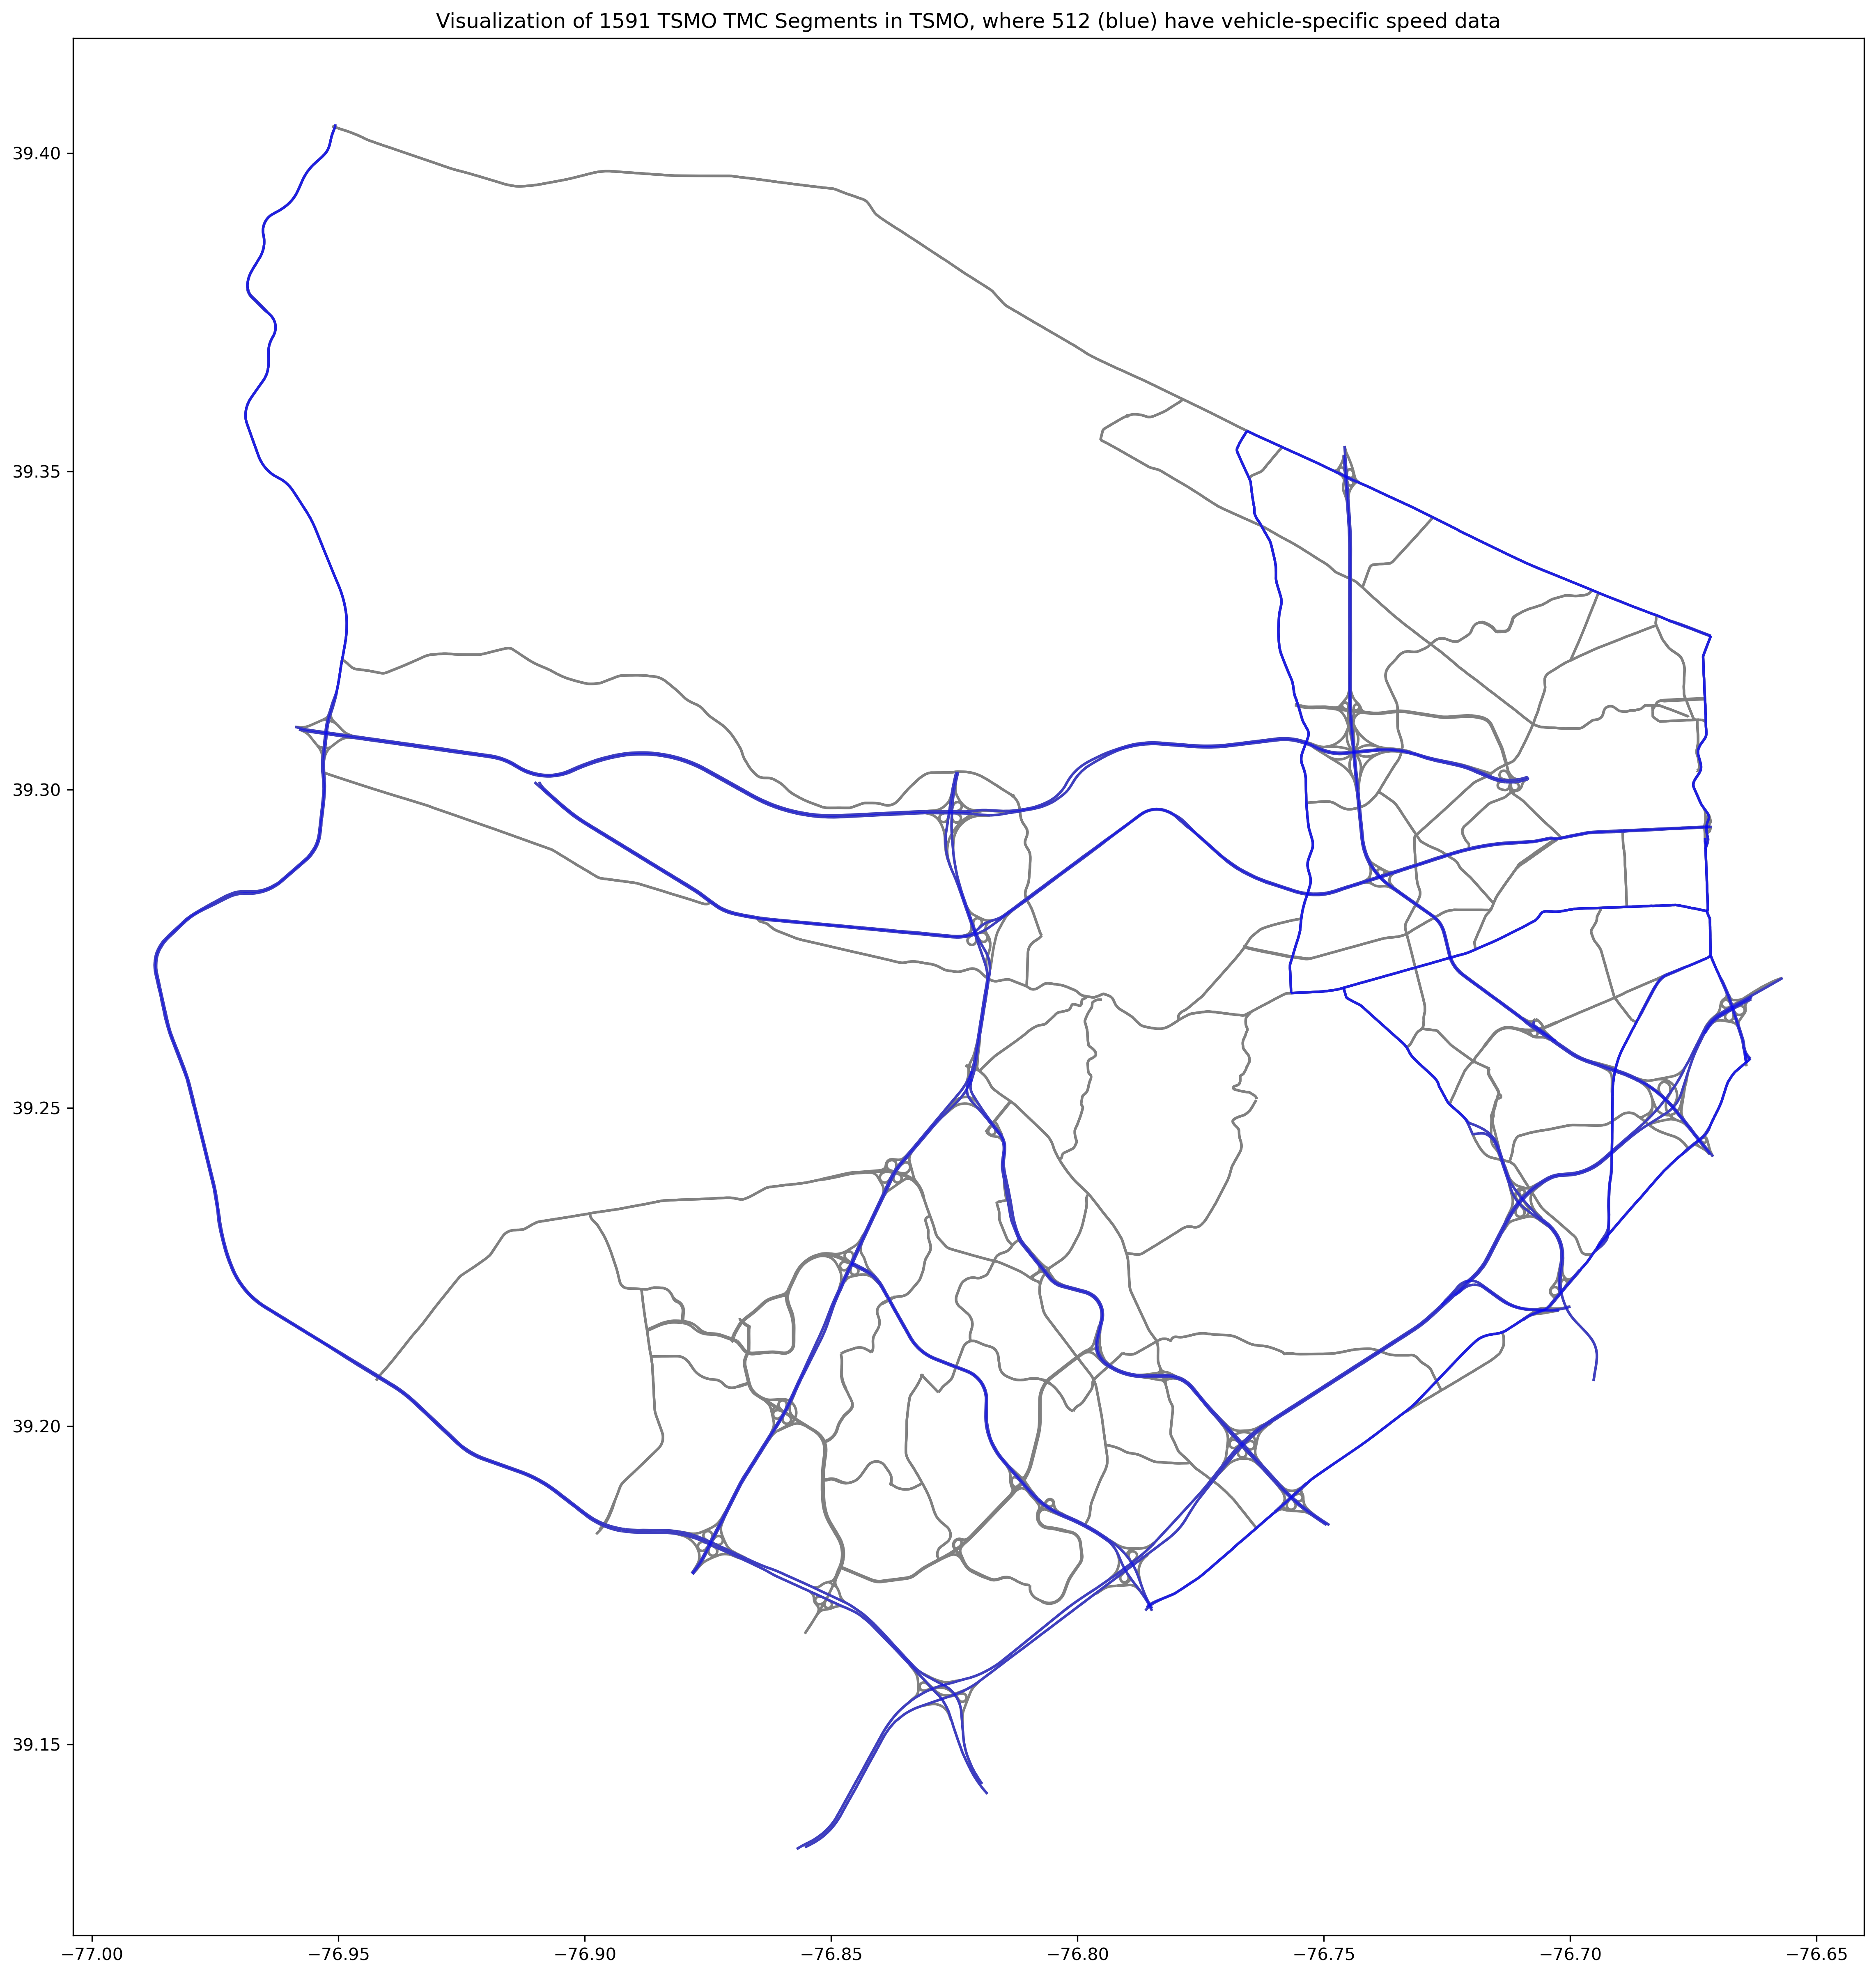

In [10]:
# Visualize and manually check segments without previous neighbors (There are 158 segments without any immediate prev neighbor)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of xxx TSMO TMC Segments in TSMO, where xxx (blue) have vehicle-specific speed data")
gdf_tmc_TSMO.plot(ax=ax, color = "grey")
gdf_tmc_TSMO[gdf_tmc_TSMO.id_tmc.isin(set_tmc_segment_vehicle.columns)].plot(ax=ax, color="blue", alpha=0.5)

#### 3.3 XD

In [ ]:
downsampled_xd_1min = pd.read_csv("/Volumes/Hao's WD/TSMO/TSMO_xd_1min/TSMO_downsampled_xd_1min.csv")

In [ ]:
df_downsampled_spd_xd_1min = pivot_df("xd", "speed", 1, df=downsampled_xd_1min, busi_date=busi_date, num_slot=930, freq=1, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_spd_xd_1min.pkl") 

In [ ]:
df_downsampled_dens_xd_1min = pivot_df("xd", "density", 1, df=downsampled_xd_1min, busi_date=busi_date, num_slot=930, freq=1, start_time=start_time, end_time=end_time, output_file_path="../data/TSMO/TSMO_df_downsampled_dens_xd_1min.pkl") 